In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as cp

 # install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
   !pip install -q pyomo
   !apt-get install -y -qq glpk-utils
   !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
   !unzip -o -q ipopt-linux64


To do
- We can linearize the system by making $B = f(\psi)$.  Basically, we grid the sin/cos for many values of $\psi$ to generate a set of $B$ matrices, then use those for evaluation.  This should give linear response and be pretty fast since we precompute these

# System Dynamics
Parameters:

- $ r $: Radius of the wheels
- $ w $: Distance from the center of mass to each wheel (half the body width)

State Variables:

- $ x $: $ x $-position of the rover's center of mass
- $ y $: $ y $-position of the rover's center of mass
- $ \psi $: Absolute heading angle of the rover (orientation of the body)
- $ \phi_L $: Absolute angle of rotation of the left wheel
- $ \phi_R $: Absolute angle of rotation of the right wheel

Inputs:

- $ \dot{\phi}_L $: Angular velocity of the left wheel
- $ \dot{\phi}_R $: Angular velocity of the right wheel

The system of differential equations describing the rover is:
$$
\begin{align}
\dot{x} &= \frac{r}{2} (\dot{\phi}_R + \dot{\phi}_L) \cos(\psi) \\
\dot{y} &= \frac{r}{2} (\dot{\phi}_R + \dot{\phi}_L) \sin(\psi) \\
\dot{\psi} &= \frac{r}{w} (\dot{\phi}_R - \dot{\phi}_L) \\
\dot{\phi}_L &= u_L \\
\dot{\phi}_R &= u_R
\end{align}
$$

We can see that the current state of the system does not directly change the system (0 input = no movement), so $A = 0, \dot{z} = Bu$.  In matrix form, this is:
$$
z = \begin{bmatrix}
            x \\
            y \\
            \psi \\
            \phi_L \\
            \phi_R
        \end{bmatrix},
u = \begin{bmatrix}
        u_L \\
        u_R
    \end{bmatrix}
$$
$$
\dot{z} = Bu \\
A = 0, B = \begin{bmatrix}
            \frac{r}{2} \cos(\psi) & \frac{r}{2} \cos(\psi) \\
            \frac{r}{2} \sin(\psi) & \frac{r}{2} \sin(\psi) \\
            -\frac{r}{w} & \frac{r}{w} \\
            1 & 0 \\
            0 & 1
            \end{bmatrix}
$$


This discretization works pretty well.  But for larger inputs, the model starts to deviate from expected.  For example, inputting movement for only one wheel should make the rover rotate and leave the other wheel at the initial position.  However, we see that the wheel deviates slightly when the inputs get larger.

[ 4.89858720e-16  1.19943766e+00  2.39381835e+00  3.57642683e+00
  4.74061406e+00  5.87983453e+00  6.98768314e+00  8.05793117e+00
  9.08456128e+00  1.00618014e+01  1.09841571e+01  1.18464426e+01
  1.26438098e+01  1.33717756e+01  1.40262472e+01  1.46035447e+01
  1.51004226e+01  1.55140871e+01  1.58422124e+01  1.60829538e+01
  1.62349577e+01  1.62973694e+01  1.62698381e+01  1.61525186e+01
  1.59460705e+01  1.56516544e+01  1.52709258e+01  1.48060251e+01
  1.42595664e+01  1.36346218e+01  1.29347052e+01  1.21637516e+01
  1.13260958e+01  1.04264472e+01  9.46986403e+00  8.46172456e+00
  7.40769690e+00  6.31370719e+00  5.18590623e+00  4.03063492e+00
  2.85438863e+00  1.66378063e+00  4.65504970e-01 -7.33701224e-01
 -1.92709557e+00 -3.10796838e+00 -4.26968035e+00 -5.40569992e+00
 -6.50963996e+00 -7.57529373e+00 -8.59666974e+00 -9.56802543e+00
 -1.04838995e+01 -1.13391425e+01 -1.21289461e+01 -1.28488696e+01
 -1.34948654e+01 -1.40633014e+01 -1.45509817e+01 -1.49551644e+01
 -1.52735771e+01 -1.55044

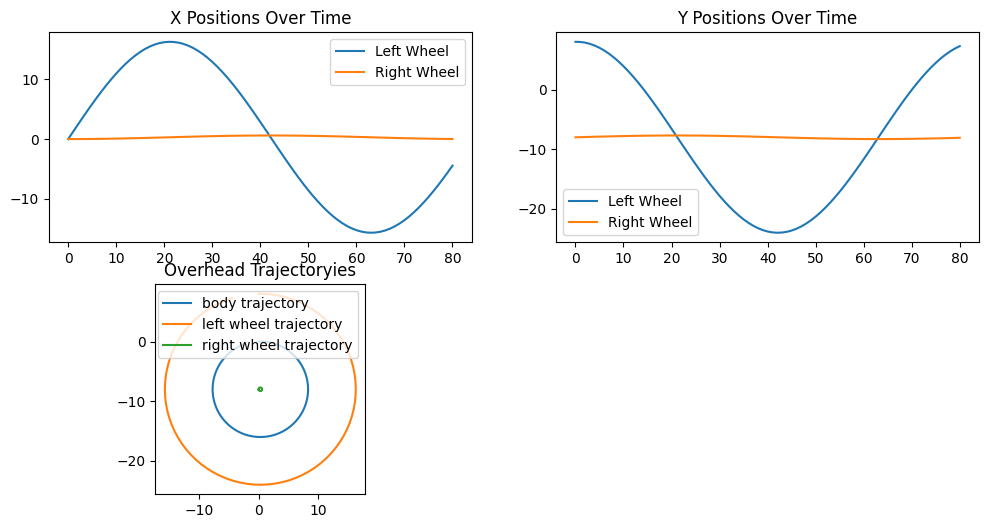

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def euler_disc_kplus1(z_k, u_k, r, w):
    x_k, y_k, psi_k, phiL_k, phiR_k = z_k

    dt = 1

    phiL_dot = u_k[0]
    phiR_dot = u_k[1]
    xdot = (r/2)*(phiR_dot + phiL_dot)*np.cos(psi_k)
    ydot = (r/2)*(phiR_dot + phiL_dot)*np.sin(psi_k)
    psidot = (r/2/w)*(phiR_dot - phiL_dot)

    x_out = x_k + xdot*dt
    y_out = y_k + ydot*dt
    psi_out = psi_k + psidot*dt
    phiL_out = phiL_k + phiL_dot*dt
    phiR_out = phiR_k + phiR_dot*dt

    z_kplus1 = np.array([x_out, y_out, psi_out, phiL_out, phiR_out])

    return z_kplus1

def simulate_rover(z0, u, N, r, w):
    trajectory = [z0]
    timesteps = range(N)
    for t in timesteps:
        trajectory.append(euler_disc_kplus1(trajectory[-1], u[t], r, w))

    trajectory = np.array(trajectory)
    x_traj, y_traj, psi_traj, phiL_traj, phiR_traj = trajectory.T

    # old wheel positions
    # wheelL_pos = np.array([x_traj, y_traj]).T + r*np.array([np.cos(psi_traj+np.pi/2), np.sin(psi_traj+np.pi/2)]).T
    # wheelR_pos = np.array([x_traj, y_traj]).T - r*np.array([np.cos(psi_traj+np.pi/2), np.sin(psi_traj+np.pi/2)]).T

    # new wheel positions
    # print(np.array([x_traj, y_traj]).T)
    wheelL_pos = np.array([x_traj, y_traj]).T + w*np.array([np.cos(psi_traj+np.pi/2), np.sin(psi_traj+np.pi/2)]).T
    wheelR_pos = np.array([x_traj, y_traj]).T - w*np.array([np.cos(psi_traj+np.pi/2), np.sin(psi_traj+np.pi/2)]).T

    return trajectory, wheelL_pos, wheelR_pos

# Simulate the system
r = 3
w = 8
N = 80
z0 = np.array([0, 0, 0, 0, 0])
u = np.tile([1, 0], (N, 1)) * 0.4

trajectory, wheelL_pos, wheelR_pos = simulate_rover(z0, u, N, r, w)
trajectory2, wheelL_pos2, wheelR_pos2 = simulate_rover(z0, u*0.5, N, r, w)


#The right wheel shuold stay in place at the origin
# Plot the right wheel position over time to verify
plt.figure(figsize=(12, 6))

# Subplot for x position
plt.subplot(2, 2, 1)
print(wheelL_pos[:,0])
plt.plot(range(N+1), wheelL_pos[:,0], label='Left Wheel')
plt.plot(range(N+1), wheelR_pos[:,0], label='Right Wheel')
plt.legend()
plt.title('X Positions Over Time')

# Subplot for y position
plt.subplot(2, 2, 2)
plt.plot(range(N+1), wheelL_pos[:,1], label='Left Wheel')
plt.plot(range(N+1), wheelR_pos[:,1], label='Right Wheel')
plt.legend()
plt.title('Y Positions Over Time')

# Subplot for overhead trajectory
plt.subplot(2, 2, 3)
ax = plt.gca()
plt.plot(trajectory[:,0],trajectory[:,1], label='body trajectory')
plt.plot(wheelL_pos[:,0],wheelL_pos[:,1], label='left wheel trajectory')
plt.plot(wheelR_pos[:,0],wheelR_pos[:,1], label='right wheel trajectory')
plt.legend()
plt.title('Overhead Trajectoryies')
ax.set_aspect('equal')

plt.show()


When we put in lower inputs, the deviation from the origin decreases, indicating that this is a discretization error.

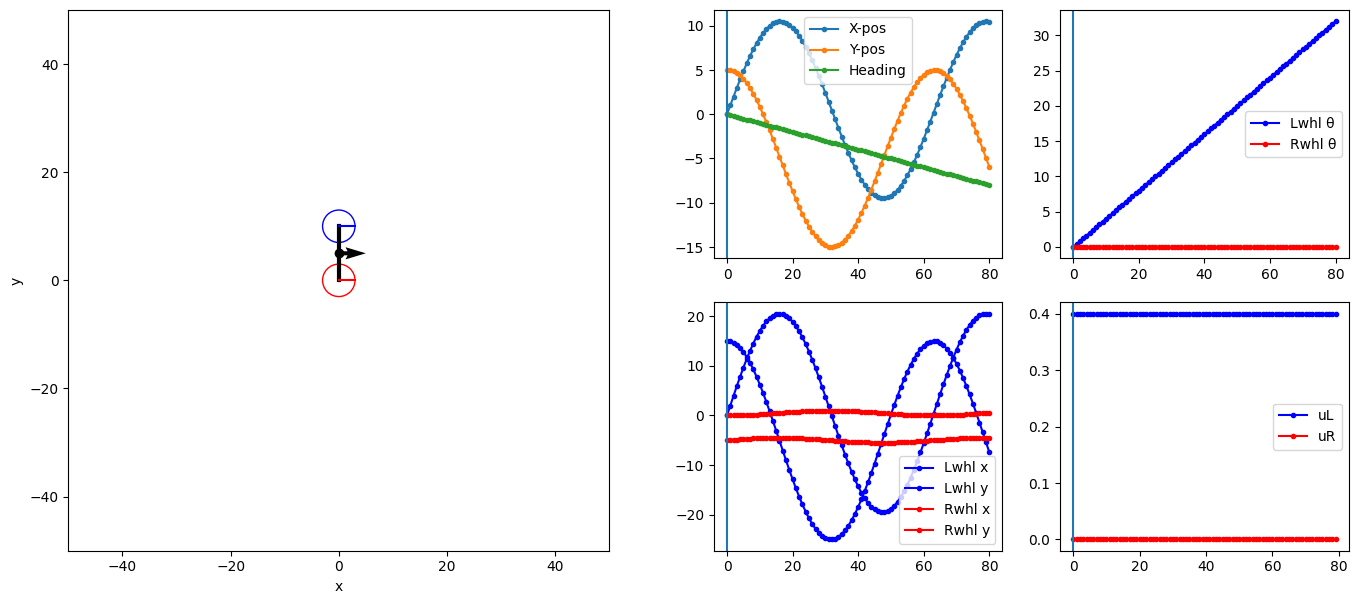

In [11]:
# Animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
import numpy as np

def plotRoverState(ax, x,y, psi, phiL,phiR, w, r_ratio):
    # Plot the rover state
    # x,y are the position of the rover
    # theta1, theta2 are the angles of the wheels
    # w is the width of the rover
    # r_ratio is the size of the wheel circles, in fraction of w

    r = r_ratio*w

    #Plot the rover body
    dx = w/2 *np.cos(psi + np.pi/2)
    dy = w/2 *np.sin(psi + np.pi/2)
    ax.plot([x-dx, x+dx], [y-dy, y+dy], 'k-', linewidth=3)

    # Plot the rover center of mass and the body as a line
    ax.plot(x,y, 'ko')

    ax.quiver(x, y, np.cos(psi), np.sin(psi), scale=20)  # heading direction

    # Plot the wheels as a circle, denoting the angle
    wheelPosL = (x+dx, y+dy)
    wheelPosR = (x-dx, y-dy)

    circle1 = Circle(wheelPosL, r, edgecolor='b', facecolor='none')
    circle2 = Circle(wheelPosR, r, edgecolor='r', facecolor='none')
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    #Show the angle markers
    ax.plot([wheelPosL[0], wheelPosL[0]+r*np.cos(phiL)],
             [wheelPosL[1], wheelPosL[1]+r*np.sin(phiL)],
             'b-')
    ax.plot([wheelPosR[0], wheelPosR[0]+r*np.cos(phiR)],
             [wheelPosR[1], wheelPosR[1]+r*np.sin(phiR)],
             'r-')

# Simulate the system
r = 5
w = 10
N = 80
z0 = np.array([0, 5, 0, 0, 0])
u = np.tile([1, 0], (N, 1)) * 0.4
trajectory, wheelL_pos, wheelR_pos = simulate_rover(z0, u, N, r, w)

# Create the figure
fig = plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Large square axes
ax1 = plt.subplot2grid((2,4), (0, 0), colspan=2, rowspan=2)  # Spans all three rows in the first column


# Four smaller plots in a 2x2 grid on the side
ax2 = plt.subplot2grid((2, 4), (0, 2))  # First row, second column
ax3 = plt.subplot2grid((2, 4), (0, 3))  # First row, third column
ax4 = plt.subplot2grid((2, 4), (1, 2))  # Second row, second column
ax5 = plt.subplot2grid((2, 4), (1, 3))  # Second row, third column

plt.tight_layout()


def update(frame):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()

    # Add axis labels
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_xlim(-50, 50)
    ax1.set_ylim(-50, 50)
    ax1.set_aspect('equal')

    # Plot the rover's state
    plotRoverState(ax1, *trajectory[frame], w, 0.3)

    x,y, psi, phiL,phiR = trajectory.T

    #Position and heading
    ax2.plot(range(N+1), x, '.-', label='X-pos')
    ax2.plot(range(N+1), y, '.-', label='Y-pos')
    ax2.plot(range(N+1), psi, '.-', label='Heading')
    ax2.axvline(frame, 0, 1)
    ax2.legend()

    #Wheel angle
    ax3.plot(range(N+1), phiL, '.-b', label="Lwhl θ")
    ax3.plot(range(N+1), phiR, '.-r', label="Rwhl θ")
    ax3.axvline(frame, 0, 1)
    ax3.legend()

    #Wheel positions
    ax4.plot(range(N+1), wheelL_pos[:,0], '.-b', label="Lwhl x")
    ax4.plot(range(N+1), wheelL_pos[:,1], '.-b', label="Lwhl y")
    ax4.plot(range(N+1), wheelR_pos[:,0], '.-r', label="Rwhl x")
    ax4.plot(range(N+1), wheelR_pos[:,1], '.-r', label="Rwhl y")
    ax4.axvline(frame, 0, 1)
    ax4.legend()

    #Inputs
    ax5.plot(range(N), u[:,0], '.-b', label="uL")
    ax5.plot(range(N), u[:,1], '.-r', label="uR")
    ax5.axvline(frame, 0, 1)
    ax5.legend()

    return ax1, ax2, ax3, ax4

# Create animation
ani = FuncAnimation(fig, update, frames=len(trajectory), repeat=False)

# Display animation in Jupyter
from IPython.display import HTML
HTML(ani.to_jshtml())


Trajectory Optimization to find control inputs s.t. thetas are driven to 0, and heading ends with same angle as initial heading


In [12]:
import pyomo.environ as pyo
T = N

def trajectory_optimization(z0):
  Ts = 1 #seconds =50 ms, 20 samples per second
  TFinal = Ts*T

  nx = 5         # number of states (x,y,theta)
  nu = 2         # number of inputs u1=v, u2=omega

  model = pyo.ConcreteModel()
  model.tidx = pyo.Set(initialize=range(0, T+1)) # length of finite optimization problem
  model.xidx = pyo.Set(initialize=range(0, nx))
  model.uidx = pyo.Set(initialize=range(0, nu))

  # Create state and input variables trajectory:
  model.z = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)

  # Constraints:
  zf=[0,0,0,0,0] # will only constrain y, psi, and phiL phiR (x is free)

  # Objective:
  model.shortest_time_cost  = sum((model.z[1, t]-zf[1])**2 for t in model.tidx if t < T)
  model.turning_cost = sum((model.u[1, t])**2 for t in model.tidx if t < T)
  model.speed_cost = sum((model.u[0, t])**2 for t in model.tidx if t < T)


  model.cost = pyo.Objective(expr = model.speed_cost, sense=pyo.minimize)


  model.constraint1 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[i, 0] == z0[i])
  model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts* (r/2)*(model.z[3,t] + model.z[4,t])*pyo.cos(model.z[2,t])
                                    if t < T else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts* (r/2)*(model.z[3,t] + model.z[4,t])*pyo.sin(model.z[2,t])
                                    if t < T else pyo.Constraint.Skip)
  model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts* (r/w)*(model.z[4,t] - model.z[3,t])
                                    if t < T else pyo.Constraint.Skip)
  model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts* model.u[0,t]
                                    if t < T else pyo.Constraint.Skip)
  model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[4, t+1] == model.z[4, t] + Ts* model.u[1,t]
                                    if t < T else pyo.Constraint.Skip)
  model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 1
                                    if t <= T-1 else pyo.Constraint.Skip)
  model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >=-1
                                    if t <= T-1 else pyo.Constraint.Skip)
  model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 1
                                    if t <= T-1 else pyo.Constraint.Skip)
  model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -1
                                    if t <= T-1 else pyo.Constraint.Skip)
  model.constraint11 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[1, T] == zf[1])

  model.constraint12 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[2, T] == zf[2])

  model.constraint13 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[3, T] == zf[3])

  model.constraint14 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[4, T] == zf[4])

  #model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t] <= 0.4
  #                                   if t <= N-1 else pyo.Constraint.Skip)


  # Now we can solve:
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  return results, model


z0=[0,0,0,3.14,3.14/2.0]
results, model = trajectory_optimization(z0)


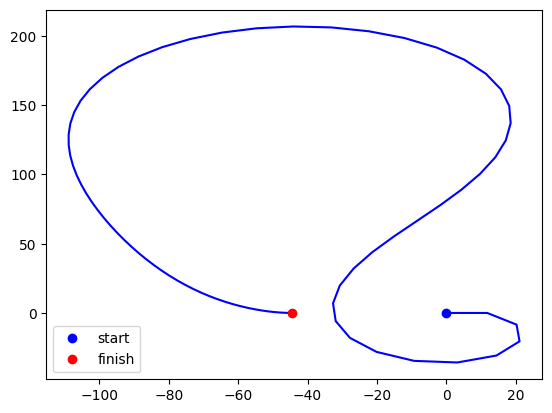

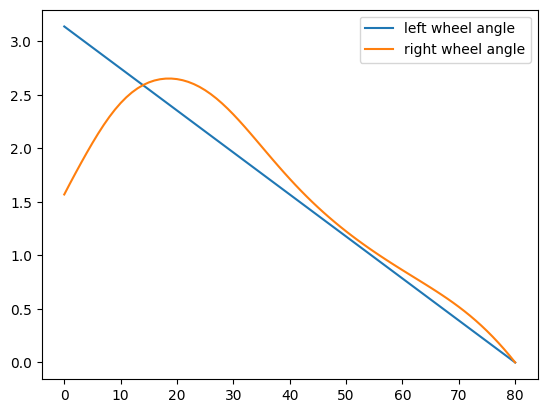

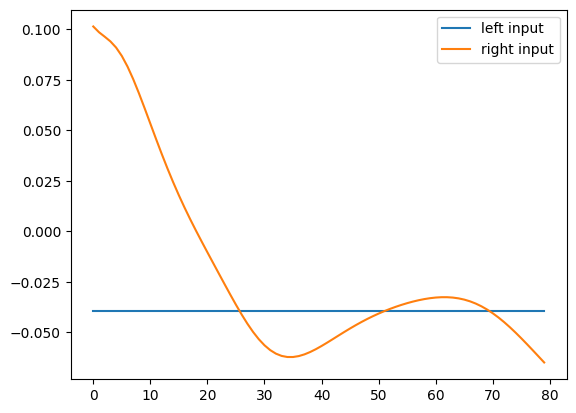

In [13]:
# plot results
z1 = [pyo.value(model.z[0,0])]
z2 = [pyo.value(model.z[1,0])]
z3 = [pyo.value(model.z[2,0])]
z4 = [pyo.value(model.z[3,0])]
z5 = [pyo.value(model.z[4,0])]
u1 = [pyo.value(model.u[0,0])]
u2 = [pyo.value(model.u[1,0])]

x = z1
y = z2
psi = z3
phiL = z4
phiR = z5

for t in model.tidx:
    if t < T:
        z1.append(pyo.value(model.z[0,t+1]))
        z2.append(pyo.value(model.z[1,t+1]))
        z3.append(pyo.value(model.z[2,t+1]))
        z4.append(pyo.value(model.z[3,t+1]))
        z5.append(pyo.value(model.z[4,t+1]))
    if t < T-1:
        u1.append(pyo.value(model.u[0,t+1]))
        u2.append(pyo.value(model.u[1,t+1]))

plt.figure(1)
plt.plot(z1, z2,'b')
plt.plot(z0[0],z0[1],'bo',label='start')
plt.plot(z1[T],z2[T],'ro',label='finish')
plt.legend()

plt.figure(2)
plt.plot(z4,label='left wheel angle')
plt.plot(z5,label='right wheel angle')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(u1,label='left input')
plt.plot(u2,label='right input')
plt.legend()
plt.show()


Trying many random combinations of initial wheel angles

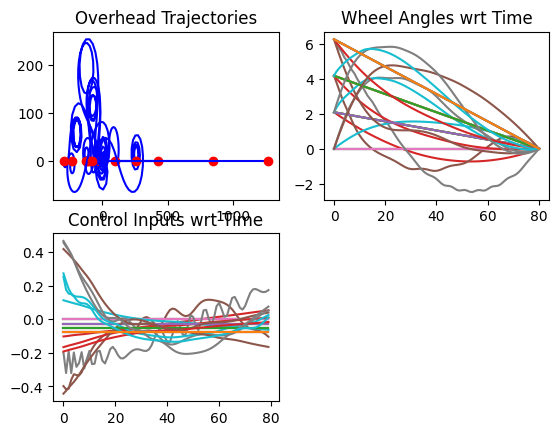

In [14]:
for thetaL in np.linspace(0,3.14*2,4):
  for thetaR in np.linspace(0,3.14*2,4):
    z0=[0,0,0,thetaL,thetaR]
    results, model = trajectory_optimization(z0)

    z1 = [pyo.value(model.z[0,0])]
    z2 = [pyo.value(model.z[1,0])]
    z3 = [pyo.value(model.z[2,0])]
    z4 = [pyo.value(model.z[3,0])]
    z5 = [pyo.value(model.z[4,0])]
    u1 = [pyo.value(model.u[0,0])]
    u2 = [pyo.value(model.u[1,0])]

    x = z1
    y = z2
    psi = z3
    phiL = z4
    phiR = z5

    for t in model.tidx:
        if t < T:
            z1.append(pyo.value(model.z[0,t+1]))
            z2.append(pyo.value(model.z[1,t+1]))
            z3.append(pyo.value(model.z[2,t+1]))
            z4.append(pyo.value(model.z[3,t+1]))
            z5.append(pyo.value(model.z[4,t+1]))
        if t < T-1:
            u1.append(pyo.value(model.u[0,t+1]))
            u2.append(pyo.value(model.u[1,t+1]))

    plt.subplot(2, 2, 1)
    plt.title('Overhead Trajectories')
    plt.plot(z1, z2,'b')
    plt.plot(z0[0],z0[1],'bo',label='start')
    plt.plot(z1[T],z2[T],'ro',label='finish')
    #plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Wheel Angles wrt Time')
    plt.plot(z4,label='left wheel angle')
    plt.plot(z5,label='right wheel angle')
    #plt.legend()

    plt.subplot(2, 2, 3)
    plt.title('Control Inputs wrt Time')
    plt.plot(u1,label='left input')
    plt.plot(u2,label='right input')
    #plt.legend()

plt.show()
